# Numerical Calculations to analyze pulse sequences

In [3]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

from floquet import pauli

In [4]:
def pseq(phases, times, delta_time, w1):
    """
    Make a pulse sequence from an arbitrary set
    of pulses with arbitrary phases and rfs
    
    Parameters
    ----------
    phases : list
        A list of phases for individual pulses (in degrees)
    times : list
        A list of times for the individual pulses
    delta_time : float
        Dwell time for the generation of the pulse sequence
    w1 : float, list
        RF amplitude for all pulses, or each of the pulses
    
    Returns
    -------
    pulse_sequence : np.ndarray
        A sequence of pulses with the "x" component
        as the real part and the "y" component as
        the imaginary part
        
        
    Example
    -------
    >>> tppm = pseq(
                phases=[0, 170,], 
                times=[4.5e-3, 4.5e-3], 
                delta_time=1e-7, 
                w1=100e3
            )
    
    """
    
    phases = [i * np.pi / 180 for i in phases]
    
    try:
        w1 = float(w1)
        pulse_sequence = [
            [w1 * np.exp(1j * p)] * int(t // delta_time)  
            for t, p in zip(times, phases) 
        ]
        
    except TypeError:
        pulse_sequence = [
            [w * np.exp(1j * p)] * int(t // delta_time)  
            for t, p, w in zip(times, phases, w1) 
        ]

    pulse_sequence = np.array([t for pulse in pulse_sequence for t in pulse])
        
    return pulse_sequence

In [6]:
def toggling_frame(start, pulse_sequence, delta_time):
    """
    Toggling frame transformation for a given pulse sequence
    
    Parameters
    ----------
    start : np.ndarray
        starting state
    pulse_sequence : np.ndarray
        A sequence of pulses with the "x" component
        as the real part and the "y" component as
        the imaginary part
    delta_time : float
        dwell time
    
    Returns
    -------
    rho : np.ndarray
        the output states for the pulse sequence
    rho_components : dict
        "x", "y", "z" component of the
        output states
    
    """
    
    I = pauli()
    
    pulse_sequence = pulse_sequence[::-1]
    
    prop_total = np.identity(2)
    
    rho = np.zeros((pulse_sequence.shape[-1] + 1, 2, 2), dtype="complex128")
    rho[0] = start
    
    rho_components = {
        i : np.zeros(rho.shape[0], dtype="complex128")
        for i in ["x", "y", "z"]
    }

    for d in ["x", "y", "z"]:
        rho_components[d][0] = np.trace(rho[0].conj().T @ I[d]) / 0.5
   
    
    for i, pulse in enumerate(pulse_sequence[::-1]):
    
        prop_current = expm( -1j * 2 * np.pi * delta_time * (pulse.real * I["x"] + pulse.imag * I["y"]) )
        prop_total = prop_current @ prop_total

        rho[i + 1] = prop_total.conj().T @ rho[0] @ prop_total

        for d in ["x", "y", "z"]:
            rho_components[d][i + 1] = np.trace(rho[i + 1].conj().T @ I[d]) / np.trace(I[d] @ I[d])
            

    # interaction frame transformation switches Iz and Ix for a pulse along Ix    
    rho_components["x"], rho_components["z"] = rho_components["z"], rho_components["x"]
    
    rho_components["zz"] = rho_components["x"] ** 2
    rho_components["yy"] = rho_components["y"] ** 2
    rho_components["xx"] = rho_components["z"] ** 2

    rho_components["zy"] = rho_components["x"] * rho_components["y"]
    rho_components["yz"] = rho_components["y"] * rho_components["z"]
    rho_components["zx"] = rho_components["z"] * rho_components["x"]

        
    return rho, rho_components
    

# XiX Decoupling

The parameters of the XiX Sequence can be changed in the cell below:

In [7]:
w1 = 100e3 # RF
tc = 14 # cycle time / tau_r
ph = np.array([0, 180,])
tm = np.array([tc / 2.0 / w1, tc / 2.0 / w1,])
dt = 1e-8


# make the sequence
xix = pseq(ph, tm, dt, w1)
I = pauli()
time = np.linspace(0, dt * xix.shape[-1], xix.shape[-1] + 1 ) * 1e6

# Visualize the XiX Sequence

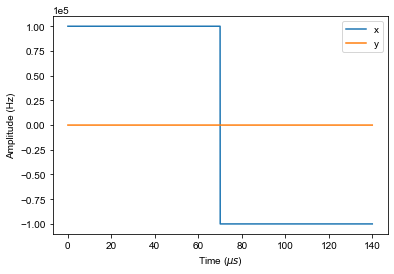

In [8]:
fig, ax = plt.subplots()
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.plot(time[:-1], xix.real, label="x")
ax.plot(time[:-1], xix.imag, label="y")
ax.set_ylabel("Amplitude (Hz)")
ax.set_xlabel("Time ($\mu s$)")
ax.legend()
plt.show()

# Toggling Frame for XiX

We will calculate the interaction frame (toggling frame) hamiltonian and then fourier transform the trajectories of the $I_x$, $I_y$, and $I_z$ projections

In [9]:
out, outc = toggling_frame(I["z"], xix, dt)
out_k = { k: np.fft.fftshift( np.fft.fft(v) ) / v.shape[-1] for k, v in outc.items() }

# Plotting the trajectories and the 1-spin Fourier coefficients

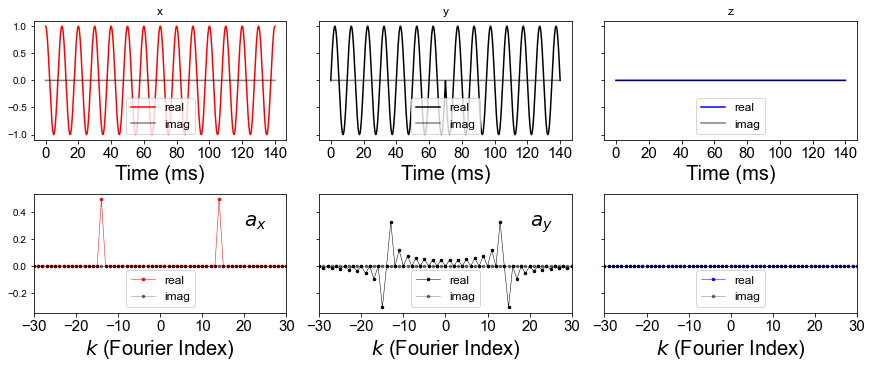

In [11]:
fig, ax  = plt.subplots(figsize=(12, 5), ncols=3, nrows=2, constrained_layout=True, sharey="row")

for axis in ax.flat:
    axis.set_facecolor("white")
    for w in ["top", "bottom", "left", "right"]:
        axis.spines[w].set_edgecolor("black")
        
    for tick in axis.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)

for c, i, (k, v) in zip(["r", "k", "b"], range(3), outc.items()):
    ax[0, i].plot(time, v.real, color=c, label="real")
    ax[0, i].plot(time, v.imag, color="k", label="imag", alpha=0.5)
    ax[0, i].legend(loc="lower center", fontsize=12)

    ax[1, i].plot([i-int(v.shape[-1]//2) for i in range(v.shape[-1])], out_k[k].real, ".-", color=c, linewidth=0.5, markersize=5, label="real")
    ax[1, i].plot([i-int(v.shape[-1]//2) for i in range(v.shape[-1])], out_k[k].imag, ".-", color="k", linewidth=0.5, markersize=5, alpha=0.5, label="imag")
    ax[1, i].legend(loc="lower center", fontsize=12)
    ax[0, i].set_title(k)
    ax[1, i].set_xlim(-30, +30)
    
ax[1, 1].text(20, 0.3, "$a_y$", fontsize=20)
ax[1, 0].text(20, 0.3, "$a_x$", fontsize=20)

for i in range(3):
    ax[1, i].set_xlabel("$k$ (Fourier Index)", fontsize=20)
    ax[0, i].set_xlabel("Time (ms)", fontsize=20)


plt.show()

# Calculating the 2nd order term from CSA x DD

The second order cross term is given by the following equation (Equation 38-39 from [Ernst M., et al 2006, Solid State Nucl. Magn. Reson. 29, 2-21](www.dx.doi.org/10.1016/j.ssnmr.2005.08.004))


$H^{(2)}_{\small{(CSA \times HetDD)}} = \frac{-1}{2} \sum_{n, k} (a^x_k a^y_{-k} - a^x_{-k} a^y_{k}) \frac{\omega^I_n \omega^{IS}_{-n} - \omega^I_{-n} \omega^{IS}_{n}}{n\omega_r + k\omega_c}$


The terms $a^x$ and $a^y$ can be seen in the above figure, and the calculation can be repeated for any value of $\tau_c$. We see that irrespective of the cycle time, the term $(a^x_k a^y_{-k} - a^x_{-k} a^y_{k})$ always evaluates to zero, since $a^x_{k} = a^x_{-k}$ and $a^y_{k} = a^y_{-k}$.

Hence, the XiX sequence is unaffected by the (2nd order) CSA $\times$ DD term 